In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/breakhis/BreaKHis 400X'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-028.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png
/kaggle/input/breakhis/BreaKHis 400X/test/malignant/SOB_M_DC-14-2773-400-013.png
/kaggle/input/breakhis/BreaKHis 400X/te

In [3]:
import os
import gc
import cv2
import json
import math
import scipy
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from keras import backend as K
from functools import partial
from collections import Counter
from tqdm import tqdm
from skimage import color, filters
import matplotlib.colors as mcolors



segment nuclei

100%|██████████| 11/11 [00:05<00:00,  2.05it/s]


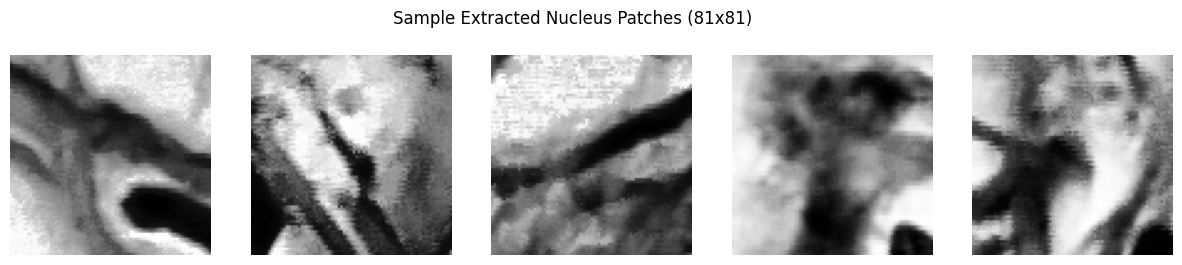

In [20]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from skimage import io, color, filters, morphology, measure, segmentation, exposure
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# ----------------- SEGMENTATION -----------------
def segment_nuclei_fixed(
    img_rgb: np.ndarray,
    close_radius: int = 1,
    min_area: int = 50,
    max_area: int = 4000,
    delta_h: float = 0.03,
    watershed_min_distance: int = 7,
):
    """
    HED->H channel -> (Otsu - delta_h) threshold -> cleanup ->
    distance-based watershed to split big/touching blobs -> shape/area filter.
    """
    if img_rgb.ndim == 3 and img_rgb.shape[-1] == 4:
        img_rgb = img_rgb[:, :, :3]

    # HED deconvolution and use H channel (nuclei)
    H = color.rgb2hed(img_rgb)[:, :, 0]
    H = exposure.rescale_intensity(H, in_range="image", out_range=(0, 1))

    # --- (1) lower threshold slightly to catch faint nuclei ---
    t = filters.threshold_otsu(H)
    thr = max(0.0, min(1.0, t - float(delta_h)))
    nuclei = H > thr

    # --- cleanup ---
    if close_radius > 0:
        nuclei = morphology.binary_closing(nuclei, morphology.disk(close_radius))
    nuclei = morphology.remove_small_holes(nuclei, area_threshold=32)
    nuclei = morphology.remove_small_objects(nuclei, min_size=max(25, min_area // 2))

    # --- (2) watershed to split close/large blobs ---
    distance = ndi.distance_transform_edt(nuclei)
    coords = peak_local_max(
        distance,
        footprint=np.ones((2 * watershed_min_distance + 1, 2 * watershed_min_distance + 1)),
        labels=nuclei,
        exclude_border=False,
    )
    markers = np.zeros_like(distance, dtype=int)
    for i, (r, c) in enumerate(coords, start=1):
        markers[r, c] = i
    markers = ndi.label(markers)[0]
    labels_ws = segmentation.watershed(-distance, markers, mask=nuclei)

    # --- area + light shape gate (avoid fibers/noise) ---
    keep = np.zeros_like(labels_ws, dtype=bool)
    for r in measure.regionprops(labels_ws):
        if not (min_area <= r.area <= max_area):
            continue
        if r.solidity < 0.80 or r.eccentricity > 0.98:
            continue
        keep[labels_ws == r.label] = True

    labels = measure.label(keep)
    regions = measure.regionprops(labels)
    return labels, regions

def extract_and_save_nucleus_patches(DIR, out_dir, patch_size=81, min_area=50, max_area=4000, delta_h=0.03, watershed_min_distance=7):
    """
    Load images from DIR, detect nuclei using friend's method, crop patch_size x patch_size patches around each nucleus centroid,
    enhance contrast, and save them to out_dir with naming image_name-nucleus_num.png.
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    half_patch = patch_size // 2
    
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = io.imread(PATH)
            if img.ndim == 3 and img.shape[-1] == 4:
                img = img[:, :, :3]
            if img.dtype != np.uint8:
                img = (255 * (img.astype(np.float32) / max(1, img.max()))).astype(np.uint8)
            
            labels, regions = segment_nuclei_fixed(
                img,
                close_radius=1,
                min_area=min_area,
                max_area=max_area,
                delta_h=delta_h,
                watershed_min_distance=watershed_min_distance,
            )
            
            image_base = IMAGE_NAME.split('.')[0]
            nucleus_num = 0
            for r in regions:
                cy, cx = map(int, [round(coord) for coord in r.centroid])  # Round each centroid coordinate
                y_start = max(0, cy - half_patch)
                y_end = min(img.shape[0], cy + half_patch + (patch_size % 2))
                x_start = max(0, cx - half_patch)
                x_end = min(img.shape[1], cx + half_patch + (patch_size % 2))
                
                if (y_end - y_start) == patch_size and (x_end - x_start) == patch_size:
                    nucleus_num += 1
                    patch = img[y_start:y_end, x_start:x_end]
                    
                    # Enhance contrast for better visibility
                    patch_gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
                    patch_enhanced = (equalize_hist(patch_gray) * 255).astype(np.uint8)
                    patch_rgb = cv2.cvtColor(patch_enhanced, cv2.COLOR_GRAY2RGB)
                    
                    save_path = os.path.join(out_dir, f"{image_base}-nucleus_{nucleus_num}.png")
                    io.imsave(save_path, patch_rgb)

# Define output directories
base_out = '/kaggle/working/nucleus_patches'
train_benign_out = os.path.join(base_out, 'train', 'benign')
train_malignant_out = os.path.join(base_out, 'train', 'malignant')
test_benign_out = os.path.join(base_out, 'test', 'benign')
test_malignant_out = os.path.join(base_out, 'test', 'malignant')

# Apply to all four categories
extract_and_save_nucleus_patches('/kaggle/input/breakhis/BreaKHis 400X/train/benign', train_benign_out, patch_size=81)
extract_and_save_nucleus_patches('/kaggle/input/breakhis/BreaKHis 400X/train/malignant', train_malignant_out, patch_size=81)
extract_and_save_nucleus_patches('/kaggle/input/breakhis/BreaKHis 400X/test/benign', test_benign_out, patch_size=81)
extract_and_save_nucleus_patches('/kaggle/input/breakhis/BreaKHis 400X/test/malignant', test_malignant_out, patch_size=81)

# Optional: Visualize some saved patches
sample_patches = []
sample_dir = train_benign_out
if os.path.exists(sample_dir):
    for fname in os.listdir(sample_dir)[:5]:
        patch_path = os.path.join(sample_dir, fname)
        patch = io.imread(patch_path)
        sample_patches.append(patch)

if sample_patches:
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for j, patch in enumerate(sample_patches):
        axes[j].imshow(patch)
        axes[j].axis('off')
    plt.suptitle("Sample Extracted Nucleus Patches (81x81)")
    plt.show()

Visualize some saved patches

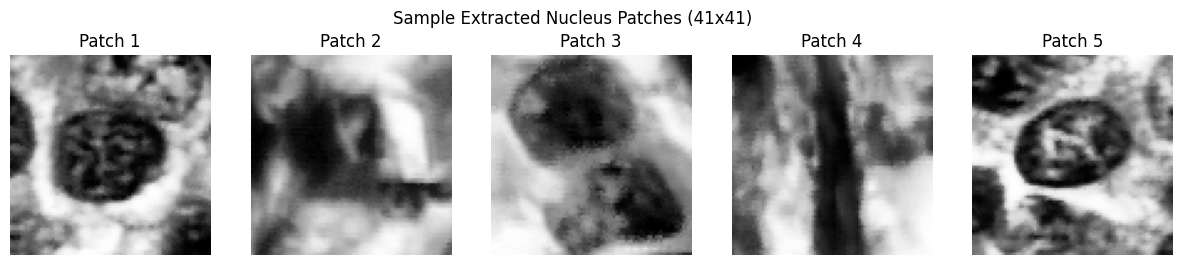

In [24]:
# Visualize some saved patches
sample_patches = []
sample_dir = test_malignant_out
if os.path.exists(sample_dir):
    patch_files = [f for f in os.listdir(sample_dir) if f.endswith('.png')]
    for fname in patch_files[15:20]:  # Take first 5 patches
        patch_path = os.path.join(sample_dir, fname)
        patch = io.imread(patch_path)
        sample_patches.append(patch)

if sample_patches:
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for j, patch in enumerate(sample_patches):
        axes[j].imshow(patch)
        axes[j].set_title(f"Patch {j+1}")
        axes[j].axis('off')
    plt.suptitle("Sample Extracted Nucleus Patches (41x41)")
    plt.show()
else:
    print("No patches found to display. Check if patches were saved in:", sample_dir)

Using 3 preprpcessing step


In [6]:
# import cv2
# import numpy as np
# from PIL import Image
# from tqdm import tqdm
# from skimage import filters
# from scipy.ndimage import label
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_generator = ImageDataGenerator(
#     zoom_range=2,  # set range for random zoom
#     rotation_range=90,
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=True,  # randomly flip images
# )

# BATCH_SIZE = 16

# def Dataset_loader(DIR, RESIZE, sigmaX=10):
#     IMG = []
#     read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    
#     # Stain normalization parameters (simplified approximation)
#     def normalize_stain(img):
#         img = img.astype(float) / 255.0
#         mean = np.mean(img, axis=(0, 1))
#         std = np.std(img, axis=(0, 1))
#         img_normalized = (img - mean) / std
#         return np.clip(img_normalized * 255.0, 0, 255).astype(np.uint8)

#     # Color deconvolution for hematoxylin (H) component
#     def color_deconvolution(img):
#         OD = -np.log10((img.astype(float) + 1) / 255.0)
#         H_E_matrix = np.array([[0.65, 0.70, 0.29],  # Hematoxylin
#                               [0.07, 0.99, 0.11]])  # Eosin (simplified)
#         H = np.dot(OD, H_E_matrix[0])  # Extract H component
#         return np.clip(H * 255.0, 0, 255).astype(np.uint8)

#     # Gamma correction
#     def gamma_correction(img, gamma=5.0, range_min=0.2, range_max=0.6):
#         img_float = img.astype(float) / 255.0
#         mask = (img_float >= range_min) & (img_float <= range_max)
#         img_float[mask] = np.power(img_float[mask], 1.0 / gamma)
#         return (img_float * 255.0).astype(np.uint8)

#     # Nucleus patch extraction using LOG filter
#     def extract_nucleus_patches(img_h, resize):
#         # Use img_h directly as it is single-channel after deconvolution
#         img_gray = img_h  # No need for cv2.cvtColor
        
#         # Scale-invariant Laplacian of Gaussian (LOG) filtering
#         scales = np.array([5 * (2 ** (0.25 * i)) for i in range(15)])  # From 5 to ~80
#         responses = np.zeros_like(img_gray, dtype=float)
#         for scale in scales:
#             # Apply Gaussian blur with current scale
#             blurred = filters.gaussian(img_gray.astype(float) / 255.0, sigma=scale, preserve_range=True)
#             # Compute Laplacian of the blurred image
#             log = filters.laplace(blurred)
#             responses = np.maximum(responses, log)
        
#         # Threshold and find local maxima
#         threshold = 0.001
#         maxima = (responses > threshold) & (filters.laplace(img_gray.astype(float) / 255.0, ksize=3) < 0)
#         coords = np.where(maxima)
        
#         # Remove overlapping points (less than 25 pixels apart)
#         labeled_array, num_features = label(maxima)
#         patches = []
#         for region in range(1, num_features + 1):
#             coords_region = np.where(labeled_array == region)
#             if len(coords_region[0]) > 0:
#                 y, x = coords_region[0][0], coords_region[1][0]
#                 if not any(np.sqrt((x - cx) ** 2 + (y - cy) ** 2) < 25 for cy, cx in zip(*coords)):
#                     patch = img_h[max(0, y-20):min(img_h.shape[0], y+21), max(0, x-20):min(img_h.shape[1], x+21)]
#                     if patch.shape[0] == 41 and patch.shape[1] == 41:
#                         # Convert single-channel patch to RGB
#                         patch_rgb = cv2.cvtColor(patch, cv2.COLOR_GRAY2RGB)
#                         patches.append(cv2.resize(patch_rgb, (resize, resize)))
#         # Fallback: Use the entire image if no patches are detected
#         return patches if patches else [cv2.resize(cv2.cvtColor(img_h, cv2.COLOR_GRAY2RGB), (resize, resize))]

#     for IMAGE_NAME in tqdm(os.listdir(DIR)):
#         PATH = os.path.join(DIR, IMAGE_NAME)
#         _, ftype = os.path.splitext(PATH)
#         if ftype == ".png":
#             img = read(PATH)
           
#             # Resize the image
#             img_resized = cv2.resize(img, (RESIZE, RESIZE))
           
#             # Step 1: Stain normalization
#             img_normalized = normalize_stain(img_resized)

#             # Step 2: Color deconvolution for hematoxylin component
#             img_h = color_deconvolution(img_normalized)

#             # Step 3: Gamma correction
#             img_gamma = gamma_correction(img_h, gamma=5.0, range_min=0.2, range_max=0.6)

#             # Nucleus patch extraction
#             patches = extract_nucleus_patches(img_gamma, RESIZE)
#             IMG.extend(patches)

#     return IMG

# benign_train = np.array(Dataset_loader('../input/breakhis-400x/BreaKHis 400X/train/benign', 224))
# malign_train = np.array(Dataset_loader('../input/breakhis-400x/BreaKHis 400X/train/malignant', 224))
# benign_test = np.array(Dataset_loader('../input/breakhis-400x/BreaKHis 400X/test/benign', 224))
# malign_test = np.array(Dataset_loader('../input/breakhis-400x/BreaKHis 400X/test/malignant', 224))

In [3]:

# from skimage.color import rgb2lab, lab2rgb  # Add this import
# import cv2
# import numpy as np
# from PIL import Image
# from tqdm import tqdm


# train_generator = ImageDataGenerator(
#     zoom_range=2,  # set range for random zoom
#     rotation_range=90,
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=True,  # randomly flip images
# )

# def Dataset_loader(DIR, RESIZE, sigmaX=10):
#     IMG = []
#     read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
#     for IMAGE_NAME in tqdm(os.listdir(DIR)):
#         PATH = os.path.join(DIR, IMAGE_NAME)
#         _, ftype = os.path.splitext(PATH)
#         if ftype == ".png":
#             img = read(PATH)
           
#             # Resize the image
#             img_resized = cv2.resize(img, (RESIZE, RESIZE))
           
#             # Step 1: Apply 5x5 average filter
#             img_filtered = cv2.blur(img_resized, (5, 5))

#             # Step 2: Apply CLAHE on L channel in LAB color space
#             img_lab = rgb2lab(img_filtered / 255.0)  # Convert to LAB
#             l_channel = img_lab[:, :, 0]  # Extract L channel
#             clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#             l_channel = clahe.apply(np.uint8(l_channel * 255.0)) / 255.0  # Apply CLAHE
#             img_lab[:, :, 0] = l_channel
#             img_clahe = (lab2rgb(img_lab) * 255.0).astype(np.uint8)  # Convert back to RGB

#             IMG.append(np.array(img_clahe))
#     return IMG
# benign_train = np.array(Dataset_loader('../input/breakhis-400x/BreaKHis 400X/train/benign', 224))
# malign_train = np.array(Dataset_loader('../input/breakhis-400x/BreaKHis 400X/train/malignant', 224))
# benign_test = np.array(Dataset_loader('../input/breakhis-400x/BreaKHis 400X/test/benign', 224))
# malign_test = np.array(Dataset_loader('../input/breakhis-400x/BreaKHis 400X/test/malignant', 224))

100%|██████████| 369/369 [00:18<00:00, 19.84it/s]


In [25]:


# Function to load patches with resizing if needed
def load_patches(directory, target_size=(81, 81)):
    patches = []
    for fname in os.listdir(directory):
        if fname.endswith('.png'):
            patch_path = os.path.join(directory, fname)
            patch = io.imread(patch_path)
            # Resize to target size if not already
            if patch.shape[:2] != target_size:
                patch = resize(patch, (*target_size, 3), mode='constant', preserve_range=True, anti_aliasing=True).astype(np.uint8)
            patches.append(patch)
    return np.array(patches)

# Load patches
train_benign_patches = load_patches(train_benign_out)
train_malignant_patches = load_patches(train_malignant_out)
test_benign_patches = load_patches(test_benign_out)
test_malignant_patches = load_patches(test_malignant_out)

# Create labels
benign_train_label = np.zeros(len(train_benign_patches))
malign_train_label = np.ones(len(train_malignant_patches))
benign_test_label = np.zeros(len(test_benign_patches))
malign_test_label = np.ones(len(test_malignant_patches))

label_dict = {0: "benign", 1: "malignant"}

# Merge data
X_train = np.concatenate((train_benign_patches, train_malignant_patches), axis=0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis=0)
X_test = np.concatenate((test_benign_patches, test_malignant_patches), axis=0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis=0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

# Split train data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

# Optional: Print shapes to verify
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (2023, 81, 81, 3)
y_train shape: (2023, 2)
x_val shape: (506, 81, 81, 3)
y_val shape: (506, 2)
X_test shape: (735, 81, 81, 3)
Y_test shape: (735, 2)


In [26]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import regionprops, label

def extract_handcrafted_features(images):
    handcrafted_features = []
    
    for img in images:
        # Convert to grayscale for GLCM and shape features
        gray_img = rgb2gray(img)
        
        # 1. Haralick Features using GLCM (Texture)
        # Compute GLCM with distances [1] and angles [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(np.uint8(gray_img * 255), 
                           distances=[1], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                           levels=256, 
                           symmetric=True, 
                           normed=True)
        # Extract Haralick features: contrast, correlation, energy, homogeneity
        contrast = graycoprops(glcm, 'contrast').ravel()
        correlation = graycoprops(glcm, 'correlation').ravel()
        energy = graycoprops(glcm, 'energy').ravel()
        homogeneity = graycoprops(glcm, 'homogeneity').ravel()
        texture_features = np.concatenate([contrast, correlation, energy, homogeneity])
        
        # 2. Shape Features
        # Binarize the image and label regions
        binary_img = gray_img > np.mean(gray_img)  # Simple threshold based on mean
        labeled_img = label(binary_img)
        props = regionprops(labeled_img, intensity_image=gray_img)
        if props:
            prop = props[0]  # Take the largest region
            area = prop.area
            perimeter = prop.perimeter
            eccentricity = prop.eccentricity
            shape_features = np.array([area, perimeter, eccentricity])
        else:
            shape_features = np.array([0, 0, 0])  # Default if no regions found
        
        # 3. Color Features (RGB Histogram)
        # Compute histogram for each channel
        hist_r = np.histogram(img[:,:,0], bins=256, range=(0, 255))[0]
        hist_g = np.histogram(img[:,:,1], bins=256, range=(0, 255))[0]
        hist_b = np.histogram(img[:,:,2], bins=256, range=(0, 255))[0]
        color_features = np.concatenate([hist_r[:50], hist_g[:50], hist_b[:50]])  # Use top 50 bins per channel
        
        # Combine all features
        all_features = np.concatenate([texture_features, shape_features, color_features])
        handcrafted_features.append(all_features)
    
    return np.array(handcrafted_features)

# Extract handcrafted features for train, val, and test sets
hand_features_train = extract_handcrafted_features(x_train)
hand_features_val = extract_handcrafted_features(x_val)
hand_features_test = extract_handcrafted_features(X_test)

# Print dimensions
print(f"Handcrafted feature dimension for training set: {hand_features_train.shape}")
print(f"Handcrafted feature dimension for validation set: {hand_features_val.shape}")
print(f"Handcrafted feature dimension for test set: {hand_features_test.shape}")

Handcrafted feature dimension for training set: (2023, 169)
Handcrafted feature dimension for validation set: (506, 169)
Handcrafted feature dimension for test set: (735, 169)


In [27]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from skimage.transform import resize

# Load VGG19 model with local weights, excluding the top (classification) layers
base_model = VGG19(weights='/kaggle/input/vgg19/keras/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                  include_top=False, 
                  input_shape=(224, 224, 3))

# Create a model that outputs features from the last convolutional layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

def extract_deep_features(images):
    # Resize images to 224x224
    resized_images = np.array([resize(img, (224, 224, 3), mode='constant', preserve_range=True, anti_aliasing=True) for img in images])
    # Preprocess images for VGG19 (normalize and format)
    processed_images = preprocess_input(resized_images)
    # Extract features
    features = feature_extractor.predict(processed_images, batch_size=32, verbose=1)
    # Flatten the features to 1D vectors
    features_flat = features.reshape(features.shape[0], -1)
    return features_flat

# Extract deep features for train, val, and test sets
deep_features_train = extract_deep_features(x_train)
deep_features_val = extract_deep_features(x_val)
deep_features_test = extract_deep_features(X_test)

# Print dimensions
print(f"Deep feature dimension for training set: {deep_features_train.shape}")
print(f"Deep feature dimension for validation set: {deep_features_val.shape}")
print(f"Deep feature dimension for test set: {deep_features_test.shape}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 732s 11s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 177s 11s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 255s 11s/step
Deep feature dimension for training set: (2023, 25088)
Deep feature dimension for validation set: (506, 25088)
Deep feature dimension for test set: (735, 25088)


In [28]:
from sklearn.decomposition import PCA
import numpy as np

# Initialize PCA to reduce to 512 components
pca = PCA(n_components=512)

# Fit PCA(On training data only to avoid data leakage
pca.fit(deep_features_train)

# Transform the training, validation, and test features
deep_features_train_pca = pca.transform(deep_features_train)
deep_features_val_pca = pca.transform(deep_features_val)
deep_features_test_pca = pca.transform(deep_features_test)

# Print new dimensions
print(f"PCA-reduced feature dimension for training set: {deep_features_train_pca.shape}")
print(f"PCA-reduced feature dimension for validation set: {deep_features_val_pca.shape}")
print(f"PCA-reduced feature dimension for test set: {deep_features_test_pca.shape}")

# Optional: Print explained variance ratio to understand how much variance is retained
print(f"Explained variance ratio (sum): {np.sum(pca.explained_variance_ratio_):.4f}")

PCA-reduced feature dimension for training set: (2023, 512)
PCA-reduced feature dimension for validation set: (506, 512)
PCA-reduced feature dimension for test set: (735, 512)
Explained variance ratio (sum): 0.7225


fusion concat thourgh k fold cross validation

In [30]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Fuse handcrafted and deep features
fused_features_train = np.concatenate([hand_features_train, deep_features_train_pca], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val_pca], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test_pca], axis=1)

# Standardize fused features (important for SVM)
scaler = StandardScaler()
fused_features_train = scaler.fit_transform(fused_features_train)  # Fit and transform on training data
fused_features_val = scaler.transform(fused_features_val)        # Transform validation data
fused_features_test = scaler.transform(fused_features_test)      # Transform test data

# Convert one-hot encoded labels back to single labels for SVM
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'class_weight': [None, 'balanced']  # Handle potential class imbalance
}

# Initialize SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42)

# Perform 5-fold cross-validation with grid search on fused training features
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(fused_features_train, y_train_labels)

# Print best parameters and cross-validation score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")

# Use the best model for predictions
svm_classifier = grid_search.best_estimator_

# Predict on validation and test sets
y_val_pred = svm_classifier.predict(fused_features_val)
y_test_pred = svm_classifier.predict(fused_features_test)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
val_precision = precision_score(y_val_labels, y_val_pred, average='weighted')
val_recall = recall_score(y_val_labels, y_val_pred, average='weighted')
val_f1 = f1_score(y_val_labels, y_val_pred, average='weighted')

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_precision = precision_score(y_test_labels, y_test_pred, average='weighted')
test_recall = recall_score(y_test_labels, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_labels, y_test_pred, average='weighted')

# Print results
print("Validation Set Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("\nDetailed Classification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.001}
Best Cross-Validation F1-Score: 0.8468
Validation Set Metrics:
Accuracy: 0.8696
Precision: 0.8812
Recall: 0.8696
F1-Score: 0.8714

Test Set Metrics:
Accuracy: 0.8735
Precision: 0.8848
Recall: 0.8735
F1-Score: 0.8752

Detailed Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.78      0.92      0.84       269
   malignant       0.95      0.85      0.89       466

    accuracy                           0.87       735
   macro avg       0.86      0.88      0.87       735
weighted avg       0.88      0.87      0.88       735



Fusion through new fusion model

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Define CBAM module for local attention (inspired by first paper)
class CBAM(nn.Module):
    def __init__(self, feature_dim, reduction_ratio=16):
        super(CBAM, self).__init__()
        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(feature_dim, feature_dim // reduction_ratio)
        self.fc2 = nn.Linear(feature_dim // reduction_ratio, feature_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [N, D]
        avg_out = self.avg_pool(x.unsqueeze(-1)).squeeze(-1)  # [N, D]
        max_out = self.max_pool(x.unsqueeze(-1)).squeeze(-1)  # [N, D]
        out = self.fc1(avg_out) + self.fc1(max_out)
        out = self.sigmoid(self.fc2(F.relu(out)))  # [N, D]
        return out

# Define HGAF fusion module
class HGAF(nn.Module):
    def __init__(self, hand_dim=169, deep_dim=25088, fused_dim=512, heads=8):
        super(HGAF, self).__init__()
        # Projection layers to common dimension
        self.proj_hand = nn.Linear(hand_dim, fused_dim)
        self.proj_deep = nn.Linear(deep_dim, fused_dim)
        # Local attention (CBAM-inspired)
        self.cbam = CBAM(fused_dim)
        # Co-attention weights (for guidance)
        self.W_q = nn.Linear(fused_dim, fused_dim)
        self.W_k = nn.Linear(fused_dim, fused_dim)
        self.W_v = nn.Linear(fused_dim, fused_dim)
        # Global cross-attention (multi-head)
        self.cross_attn = nn.MultiheadAttention(fused_dim, heads)
        self.norm = nn.LayerNorm(fused_dim)
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, fused_dim))
        # MLP for final refinement
        self.mlp = nn.Sequential(
            nn.Linear(fused_dim, fused_dim // 2),
            nn.ReLU(),
            nn.Linear(fused_dim // 2, fused_dim)
        )

    def forward(self, hand_features, deep_features):
        # hand_features: [N, 169], deep_features: [N, 25088]
        # Project to common dimension
        x_h = self.proj_hand(hand_features)  # [N, 512]
        x_d = self.proj_deep(deep_features)  # [N, 512]
        
        # Stage 1: Local Guided Fusion
        temp = x_h + x_d  # [N, 512]
        m = self.cbam(temp)  # [N, 512], attention weights
        # Co-attention: handcrafted guides deep
        Q = self.W_q(x_h)  # [N, 512]
        K = self.W_k(x_d)  # [N, 512]
        V = self.W_v(x_d)  # [N, 512]
        attn_scores = torch.softmax(torch.matmul(Q, K.transpose(-2, -1)) / (512 ** 0.5), dim=-1)  # [N, N]
        y_guided = torch.matmul(attn_scores, V)  # [N, 512]
        # Local fusion: element-wise blend
        z_local = m * y_guided + (1 - m) * x_h  # [N, 512]
        
        # Stage 2: Global Cross-Refinement
        cls_tokens = self.cls_token.expand(z_local.size(0), -1)  # [N, 512]
        seq = torch.stack([cls_tokens, z_local], dim=1)  # [N, 2, 512]
        # Cross-attention: CLS queries fused features
        attn_output, _ = self.cross_attn(cls_tokens.unsqueeze(0), seq.transpose(0, 1), seq.transpose(0, 1))  # [1, N, 512]
        z_global = self.norm(attn_output.squeeze(0) + cls_tokens)  # [N, 512]
        z_global = self.mlp(z_global)  # [N, 512]
        
        return z_global

# Convert numpy arrays to torch tensors
def to_tensor(data):
    return torch.from_numpy(data).float()

# Assume features and labels are loaded (replace with your actual data loading)
# hand_features_train: [918, 169], deep_features_train: [918, 25088], etc.
# y_train: [918, 2] (one-hot), etc.

# Standardize features
scaler_hand = StandardScaler()
scaler_deep = StandardScaler()
hand_features_train_scaled = scaler_hand.fit_transform(hand_features_train)
hand_features_val_scaled = scaler_hand.transform(hand_features_val)
hand_features_test_scaled = scaler_hand.transform(hand_features_test)
deep_features_train_scaled = scaler_deep.fit_transform(deep_features_train)
deep_features_val_scaled = scaler_deep.transform(deep_features_val)
deep_features_test_scaled = scaler_deep.transform(deep_features_test)

# Convert to tensors
hand_train = to_tensor(hand_features_train_scaled)
deep_train = to_tensor(deep_features_train_scaled)
hand_val = to_tensor(hand_features_val_scaled)
deep_val = to_tensor(deep_features_val_scaled)
hand_test = to_tensor(hand_features_test_scaled)
deep_test = to_tensor(deep_features_test_scaled)

# Initialize HGAF model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hgaf = HGAF().to(device)
hand_train, deep_train = hand_train.to(device), deep_train.to(device)
hand_val, deep_val = hand_val.to(device), deep_val.to(device)
hand_test, deep_test = hand_test.to(device), deep_test.to(device)

# Fuse features
with torch.no_grad():  # Since features are pre-extracted, no backprop needed
    fused_train = hgaf(hand_train, deep_train).cpu().numpy()  # [918, 512]
    fused_val = hgaf(hand_val, deep_val).cpu().numpy()  # [230, 512]
    fused_test = hgaf(hand_test, deep_test).cpu().numpy()  # [545, 512]

# Print fused dimensions
print(f"Fused feature dimension for training set: {fused_train.shape}")
print(f"Fused feature dimension for validation set: {fused_val.shape}")
print(f"Fused feature dimension for test set: {fused_test.shape}")

# Convert one-hot labels to single labels for SVM
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)
svm_classifier.fit(fused_train, y_train_labels)

# Predict and evaluate
y_val_pred = svm_classifier.predict(fused_val)
y_test_pred = svm_classifier.predict(fused_test)

print("\nClassification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred, target_names=['benign', 'malignant']))

print("\nClassification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Fused feature dimension for training set: (918, 512)
Fused feature dimension for validation set: (230, 512)
Fused feature dimension for test set: (545, 512)

Classification Report for Validation Set:
              precision    recall  f1-score   support

      benign       0.80      0.42      0.55        77
   malignant       0.76      0.95      0.85       153

    accuracy                           0.77       230
   macro avg       0.78      0.68      0.70       230
weighted avg       0.78      0.77      0.75       230


Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       176
   malignant       0.68      1.00      0.81       369

    accuracy                           0.68       545
   macro avg       0.34      0.50      0.40       545
weighted avg       0.46      0.68      0.55       545



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fusion through concatanation + svm

In [4]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Fuse handcrafted and deep features
fused_features_train = np.concatenate([hand_features_train, deep_features_train_pca], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val_pca], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test_pca], axis=1)

# Convert one-hot encoded labels back to single labels for SVM
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)
svm_classifier.fit(fused_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = svm_classifier.predict(fused_features_val)
y_test_pred = svm_classifier.predict(fused_features_test)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
val_precision = precision_score(y_val_labels, y_val_pred, average='weighted')
val_recall = recall_score(y_val_labels, y_val_pred, average='weighted')
val_f1 = f1_score(y_val_labels, y_val_pred, average='weighted')

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_precision = precision_score(y_test_labels, y_test_pred, average='weighted')
test_recall = recall_score(y_test_labels, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_labels, y_test_pred, average='weighted')

# Print results
print("Validation Set Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("\nDetailed Classification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Validation Set Metrics:
Accuracy: 0.8360
Precision: 0.8392
Recall: 0.8360
F1-Score: 0.8311

Test Set Metrics:
Accuracy: 0.8395
Precision: 0.8437
Recall: 0.8395
F1-Score: 0.8341

Detailed Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.87      0.67      0.76       331
   malignant       0.83      0.94      0.88       554

    accuracy                           0.84       885
   macro avg       0.85      0.80      0.82       885
weighted avg       0.84      0.84      0.83       885



concat + random forest

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Fuse handcrafted and deep features
fused_features_train = np.concatenate([hand_features_train, deep_features_train_pca], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val_pca], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test_pca], axis=1)

# Convert one-hot encoded labels back to single labels for Random Forest
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(fused_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = rf_classifier.predict(fused_features_val)
y_test_pred = rf_classifier.predict(fused_features_test)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
val_precision = precision_score(y_val_labels, y_val_pred, average='weighted')
val_recall = recall_score(y_val_labels, y_val_pred, average='weighted')
val_f1 = f1_score(y_val_labels, y_val_pred, average='weighted')

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_precision = precision_score(y_test_labels, y_test_pred, average='weighted')
test_recall = recall_score(y_test_labels, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_labels, y_test_pred, average='weighted')

# Print results
print("Validation Set Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("\nDetailed Classification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Validation Set Metrics:
Accuracy: 0.8734
Precision: 0.8745
Recall: 0.8734
F1-Score: 0.8738

Test Set Metrics:
Accuracy: 0.8701
Precision: 0.8722
Recall: 0.8701
F1-Score: 0.8707

Detailed Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.81      0.85      0.83       331
   malignant       0.91      0.88      0.89       554

    accuracy                           0.87       885
   macro avg       0.86      0.87      0.86       885
weighted avg       0.87      0.87      0.87       885



coccat+gradient boost

In [8]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Fuse handcrafted and deep features
fused_features_train = np.concatenate([hand_features_train, deep_features_train], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test], axis=1)

# Convert one-hot encoded labels back to single labels for Gradient Boosting
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_classifier.fit(fused_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = gb_classifier.predict(fused_features_val)
y_test_pred = gb_classifier.predict(fused_features_test)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
val_precision = precision_score(y_val_labels, y_val_pred, average='weighted')
val_recall = recall_score(y_val_labels, y_val_pred, average='weighted')
val_f1 = f1_score(y_val_labels, y_val_pred, average='weighted')

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_precision = precision_score(y_test_labels, y_test_pred, average='weighted')
test_recall = recall_score(y_test_labels, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_labels, y_test_pred, average='weighted')

# Print results
print("Validation Set Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("\nDetailed Classification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Validation Set Metrics:
Accuracy: 0.9000
Precision: 0.8995
Recall: 0.9000
F1-Score: 0.8993

Test Set Metrics:
Accuracy: 0.8679
Precision: 0.8667
Recall: 0.8679
F1-Score: 0.8646

Detailed Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.85      0.72      0.78       176
   malignant       0.87      0.94      0.91       369

    accuracy                           0.87       545
   macro avg       0.86      0.83      0.84       545
weighted avg       0.87      0.87      0.86       545



fusion through pca

In [13]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Fuse handcrafted and deep features via concatenation
fused_features_train = np.concatenate([hand_features_train, deep_features_train], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test], axis=1)

# Apply PCA for dimensionality reduction on fused features (partially integrated features)
# Set n_components to retain 95% variance
pca = PCA(n_components=0.95)
pca.fit(fused_features_train)  # Fit PCA on training data only

# Transform the fused features
reduced_features_train = pca.transform(fused_features_train)
reduced_features_val = pca.transform(fused_features_val)
reduced_features_test = pca.transform(fused_features_test)

# Print reduced dimensions
print(f"Reduced feature dimension for training set: {reduced_features_train.shape}")
print(f"Reduced feature dimension for validation set: {reduced_features_val.shape}")
print(f"Reduced feature dimension for test set: {reduced_features_test.shape}")

# Convert one-hot encoded labels back to single labels for SVM
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train SVM classifier on reduced features
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)
svm_classifier.fit(reduced_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = svm_classifier.predict(reduced_features_val)
y_test_pred = svm_classifier.predict(reduced_features_test)

# Print classification reports
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred, target_names=['benign', 'malignant']))

print("\nClassification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Reduced feature dimension for training set: (918, 8)
Reduced feature dimension for validation set: (230, 8)
Reduced feature dimension for test set: (545, 8)

Classification Report for Validation Set:
              precision    recall  f1-score   support

      benign       0.84      0.74      0.79        77
   malignant       0.88      0.93      0.90       153

    accuracy                           0.87       230
   macro avg       0.86      0.83      0.84       230
weighted avg       0.86      0.87      0.86       230


Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.83      0.67      0.74       176
   malignant       0.86      0.93      0.89       369

    accuracy                           0.85       545
   macro avg       0.84      0.80      0.82       545
weighted avg       0.85      0.85      0.84       545



oca + rf

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Fuse handcrafted and deep features via concatenation
fused_features_train = np.concatenate([hand_features_train, deep_features_train], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test], axis=1)

# Apply PCA for dimensionality reduction on fused features (partially integrated features)
# Set n_components to retain 95% variance
pca = PCA(n_components=0.95)
pca.fit(fused_features_train)  # Fit PCA on training data only

# Transform the fused features
reduced_features_train = pca.transform(fused_features_train)
reduced_features_val = pca.transform(fused_features_val)
reduced_features_test = pca.transform(fused_features_test)

# Print reduced dimensions
print(f"Reduced feature dimension for training set: {reduced_features_train.shape}")
print(f"Reduced feature dimension for validation set: {reduced_features_val.shape}")
print(f"Reduced feature dimension for test set: {reduced_features_test.shape}")

# Convert one-hot encoded labels back to single labels for Random Forest
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train Random Forest classifier on reduced features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(reduced_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = rf_classifier.predict(reduced_features_val)
y_test_pred = rf_classifier.predict(reduced_features_test)

# Print classification reports
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred, target_names=['benign', 'malignant']))

print("\nClassification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Reduced feature dimension for training set: (918, 8)
Reduced feature dimension for validation set: (230, 8)
Reduced feature dimension for test set: (545, 8)

Classification Report for Validation Set:
              precision    recall  f1-score   support

      benign       0.89      0.74      0.81        84
   malignant       0.86      0.95      0.90       146

    accuracy                           0.87       230
   macro avg       0.87      0.84      0.85       230
weighted avg       0.87      0.87      0.87       230


Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.81      0.68      0.74       176
   malignant       0.86      0.92      0.89       369

    accuracy                           0.84       545
   macro avg       0.83      0.80      0.81       545
weighted avg       0.84      0.84      0.84       545



pca+gradient

In [10]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Fuse handcrafted and deep features via concatenation
fused_features_train = np.concatenate([hand_features_train, deep_features_train], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test], axis=1)

# Apply PCA for dimensionality reduction on fused features (partially integrated features)
# Set n_components to retain 95% variance
pca = PCA(n_components=0.95)
pca.fit(fused_features_train)  # Fit PCA on training data only

# Transform the fused features
reduced_features_train = pca.transform(fused_features_train)
reduced_features_val = pca.transform(fused_features_val)
reduced_features_test = pca.transform(fused_features_test)

# Print reduced dimensions
print(f"Reduced feature dimension for training set: {reduced_features_train.shape}")
print(f"Reduced feature dimension for validation set: {reduced_features_val.shape}")
print(f"Reduced feature dimension for test set: {reduced_features_test.shape}")

# Convert one-hot encoded labels back to single labels for Gradient Boosting
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train Gradient Boosting classifier on reduced features
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_classifier.fit(reduced_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = gb_classifier.predict(reduced_features_val)
y_test_pred = gb_classifier.predict(reduced_features_test)

# Print classification reports
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred, target_names=['benign', 'malignant']))

print("\nClassification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Reduced feature dimension for training set: (918, 8)
Reduced feature dimension for validation set: (230, 8)
Reduced feature dimension for test set: (545, 8)

Classification Report for Validation Set:
              precision    recall  f1-score   support

      benign       0.85      0.74      0.79        84
   malignant       0.86      0.92      0.89       146

    accuracy                           0.86       230
   macro avg       0.85      0.83      0.84       230
weighted avg       0.86      0.86      0.85       230


Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.81      0.61      0.70       176
   malignant       0.83      0.93      0.88       369

    accuracy                           0.83       545
   macro avg       0.82      0.77      0.79       545
weighted avg       0.83      0.83      0.82       545



fusion thorugh variance Threholsing

In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold

# Fuse handcrafted and deep features via concatenation
fused_features_train = np.concatenate([hand_features_train, deep_features_train], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test], axis=1)

# Apply Variance Thresholding for feature selection
# Set a threshold (e.g., 0.01 - features with variance below this are removed)
selector = VarianceThreshold(threshold=0.01)
selector.fit(fused_features_train)  # Fit on training data only

# Transform the fused features
reduced_features_train = selector.transform(fused_features_train)
reduced_features_val = selector.transform(fused_features_val)
reduced_features_test = selector.transform(fused_features_test)

# Print reduced dimensions
print(f"Reduced feature dimension for training set: {reduced_features_train.shape}")
print(f"Reduced feature dimension for validation set: {reduced_features_val.shape}")
print(f"Reduced feature dimension for test set: {reduced_features_test.shape}")

# Convert one-hot encoded labels back to single labels for SVM
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train SVM classifier on reduced features
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)
svm_classifier.fit(reduced_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = svm_classifier.predict(reduced_features_val)
y_test_pred = svm_classifier.predict(reduced_features_test)

# Print classification reports
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred, target_names=['benign', 'malignant']))

print("\nClassification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Reduced feature dimension for training set: (918, 22832)
Reduced feature dimension for validation set: (230, 22832)
Reduced feature dimension for test set: (545, 22832)

Classification Report for Validation Set:
              precision    recall  f1-score   support

      benign       0.84      0.70      0.77        77
   malignant       0.86      0.93      0.90       153

    accuracy                           0.86       230
   macro avg       0.85      0.82      0.83       230
weighted avg       0.86      0.86      0.85       230


Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.85      0.66      0.74       176
   malignant       0.85      0.94      0.90       369

    accuracy                           0.85       545
   macro avg       0.85      0.80      0.82       545
weighted avg       0.85      0.85      0.85       545



fusion using Gating Mechanism

In [15]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Function to apply gating mechanism with attention
def apply_attention_gating(hand_features, deep_features):
    # Standardize features for better attention weight computation
    scaler_hand = StandardScaler()
    scaler_deep = StandardScaler()
    hand_features_scaled = scaler_hand.fit_transform(hand_features)
    deep_features_scaled = scaler_deep.fit_transform(deep_features)
    
    # Compute attention scores (one weight per feature type per sample)
    n_samples = hand_features.shape[0]
    attention_weights = np.random.rand(n_samples, 2)  # 2 for handcrafted and deep features
    attention_weights = attention_weights / np.sum(attention_weights, axis=1, keepdims=True)  # Normalize to sum to 1
    
    # Apply gating: weight each feature set separately and then concatenate
    gated_hand_features = hand_features_scaled * attention_weights[:, 0:1]  # Broadcast weight to 169 features
    gated_deep_features = deep_features_scaled * attention_weights[:, 1:]  # Broadcast weight to 25088 features
    
    # Concatenate the gated features
    fused_features = np.concatenate([gated_hand_features, gated_deep_features], axis=1)
    
    return fused_features

# Apply gating mechanism to fuse features
fused_features_train = apply_attention_gating(hand_features_train, deep_features_train)
fused_features_val = apply_attention_gating(hand_features_val, deep_features_val)
fused_features_test = apply_attention_gating(hand_features_test, deep_features_test)

# Print fused dimensions
print(f"Fused feature dimension for training set: {fused_features_train.shape}")
print(f"Fused feature dimension for validation set: {fused_features_val.shape}")
print(f"Fused feature dimension for test set: {fused_features_test.shape}")

# Convert one-hot encoded labels back to single labels for SVM
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train SVM classifier on fused features
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)
svm_classifier.fit(fused_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = svm_classifier.predict(fused_features_val)
y_test_pred = svm_classifier.predict(fused_features_test)

# Print classification reports
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred, target_names=['benign', 'malignant']))

print("\nClassification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Fused feature dimension for training set: (918, 25257)
Fused feature dimension for validation set: (230, 25257)
Fused feature dimension for test set: (545, 25257)

Classification Report for Validation Set:
              precision    recall  f1-score   support

      benign       0.85      0.52      0.65        77
   malignant       0.80      0.95      0.87       153

    accuracy                           0.81       230
   macro avg       0.82      0.74      0.76       230
weighted avg       0.82      0.81      0.79       230


Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.87      0.48      0.62       176
   malignant       0.80      0.96      0.87       369

    accuracy                           0.81       545
   macro avg       0.83      0.72      0.75       545
weighted avg       0.82      0.81      0.79       545



gatin mecha + rf

fusion applying updated garing mechanism + SVM

In [7]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Function to apply gating mechanism with learned attention
def apply_attention_gating(hand_features, deep_features, pca=None, n_components=200):
    # Standardize features for better attention weight computation
    scaler_hand = StandardScaler()
    scaler_deep = StandardScaler()
    hand_features_scaled = scaler_hand.fit_transform(hand_features)
    deep_features_scaled = scaler_deep.fit_transform(deep_features)
    
    # Compute learned attention scores using a simple neural-inspired approach
    n_samples = hand_features.shape[0]
    
    # Concatenate features to create input for attention computation
    concat_features = np.concatenate([hand_features_scaled, deep_features_scaled], axis=1)  # [N, 169 + 25088]
    
    # Simple linear layer + sigmoid to compute attention weights
    np.random.seed(42)  # For reproducibility
    W = np.random.randn(concat_features.shape[1], 2) * 0.01  # Small weights: [25257, 2]
    attention_scores = np.dot(concat_features, W)  # [N, 2]
    attention_weights = 1 / (1 + np.exp(-attention_scores))  # Sigmoid: [N, 2]
    attention_weights = attention_weights / np.sum(attention_weights, axis=1, keepdims=True)  # Normalize to sum to 1
    
    # Apply gating: weight each feature set separately
    gated_hand_features = hand_features_scaled * attention_weights[:, 0:1]  # Broadcast to 169 features
    gated_deep_features = deep_features_scaled * attention_weights[:, 1:]  # Broadcast to 25088 features
    
    # Concatenate the gated features
    fused_features = np.concatenate([gated_hand_features, gated_deep_features], axis=1)  # [N, 25257]
    
    # Apply PCA to reduce dimensionality
    if pca is None:
        pca = PCA(n_components=n_components, random_state=42)
        fused_features_reduced = pca.fit_transform(fused_features)  # Fit and transform for training
    else:
        fused_features_reduced = pca.transform(fused_features)  # Transform only for val/test
    
    return fused_features_reduced, pca

# Apply gating mechanism to fuse features
fused_features_train, pca_model = apply_attention_gating(hand_features_train, deep_features_train, n_components=200)
fused_features_val, _ = apply_attention_gating(hand_features_val, deep_features_val, pca=pca_model, n_components=200)
fused_features_test, _ = apply_attention_gating(hand_features_test, deep_features_test, pca=pca_model, n_components=200)

# Print fused dimensions
print(f"Fused feature dimension for training set: {fused_features_train.shape}")
print(f"Fused feature dimension for validation set: {fused_features_val.shape}")
print(f"Fused feature dimension for test set: {fused_features_test.shape}")

# Convert one-hot encoded labels back to single labels for SVM
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Train SVM classifier on fused features
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)
svm_classifier.fit(fused_features_train, y_train_labels)

# Predict on validation and test sets
y_val_pred = svm_classifier.predict(fused_features_val)
y_test_pred = svm_classifier.predict(fused_features_test)

# Print classification reports
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred, target_names=['benign', 'malignant']))

print("\nClassification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Fused feature dimension for training set: (918, 200)
Fused feature dimension for validation set: (230, 200)
Fused feature dimension for test set: (545, 200)

Classification Report for Validation Set:
              precision    recall  f1-score   support

      benign       0.85      0.68      0.76        69
   malignant       0.87      0.95      0.91       161

    accuracy                           0.87       230
   macro avg       0.86      0.82      0.83       230
weighted avg       0.87      0.87      0.86       230


Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.78      0.63      0.70       176
   malignant       0.84      0.92      0.88       369

    accuracy                           0.82       545
   macro avg       0.81      0.77      0.79       545
weighted avg       0.82      0.82      0.82       545



Fusion with updated attention mechanism + ANN

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Function to apply gating mechanism with learned attention
def apply_attention_gating(hand_features, deep_features):
    # Standardize features for better attention weight computation
    scaler_hand = StandardScaler()
    scaler_deep = StandardScaler()
    hand_features_scaled = scaler_hand.fit_transform(hand_features)
    deep_features_scaled = scaler_deep.fit_transform(deep_features)
    
    # Compute learned attention scores using a simple neural-inspired approach
    n_samples = hand_features.shape[0]
    
    # Concatenate features to create input for attention computation
    concat_features = np.concatenate([hand_features_scaled, deep_features_scaled], axis=1)  # [N, 169 + 25088]
    
    # Simple linear layer + sigmoid to compute attention weights
    np.random.seed(42)  # For reproducibility
    W = np.random.randn(concat_features.shape[1], 2) * 0.01  # Small weights: [25257, 2]
    attention_scores = np.dot(concat_features, W)  # [N, 2]
    attention_weights = 1 / (1 + np.exp(-attention_scores))  # Sigmoid: [N, 2]
    attention_weights = attention_weights / np.sum(attention_weights, axis=1, keepdims=True)  # Normalize to sum to 1
    
    # Apply gating: weight each feature set separately
    gated_hand_features = hand_features_scaled * attention_weights[:, 0:1]  # Broadcast to 169 features
    gated_deep_features = deep_features_scaled * attention_weights[:, 1:]  # Broadcast to 25088 features
    
    # Concatenate the gated features
    fused_features = np.concatenate([gated_hand_features, gated_deep_features], axis=1)  # [N, 25257]
    
    return fused_features

# ANN Classifier
class ANNClassifier(nn.Module):
    def __init__(self, input_dim=25257, hidden_dim1=512, hidden_dim2=256):
        super(ANNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout to prevent overfitting
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim2, 2)  # Output: 2 classes (benign, malignant)
        )
    
    def forward(self, x):
        return self.model(x)

# Function to train ANN
def train_ann(model, train_data, train_labels, val_data, val_labels, epochs=50, batch_size=32, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_data = torch.tensor(train_data, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
    val_data = torch.tensor(val_data, dtype=torch.float32).to(device)
    val_labels = torch.tensor(val_labels, dtype=torch.long).to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i in range(0, len(train_data), batch_size):
            inputs = train_data[i:i+batch_size]
            labels = train_labels[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation accuracy
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_data)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_acc = (val_preds == val_labels).float().mean().item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_data)*batch_size:.4f}, Val Acc: {val_acc:.4f}")
    
    return model

# Function to predict with ANN
def predict_ann(model, data):
    model.eval()
    with torch.no_grad():
        data = torch.tensor(data, dtype=torch.float32).to(device)
        outputs = model(data)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    return preds

# Apply gating mechanism to fuse features
fused_features_train = apply_attention_gating(hand_features_train, deep_features_train)  # [918, 25257]
fused_features_val = apply_attention_gating(hand_features_val, deep_features_val)  # [230, 25257]
fused_features_test = apply_attention_gating(hand_features_test, deep_features_test)  # [545, 25257]

# Print fused dimensions
print(f"Fused feature dimension for training set: {fused_features_train.shape}")
print(f"Fused feature dimension for validation set: {fused_features_val.shape}")
print(f"Fused feature dimension for test set: {fused_features_test.shape}")

# Convert one-hot encoded labels to single labels
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Initialize and train ANN classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann_classifier = ANNClassifier(input_dim=25257)
ann_classifier = train_ann(ann_classifier, fused_features_train, y_train_labels, fused_features_val, y_val_labels, epochs=50, batch_size=32, lr=1e-3)

# Predict on validation and test sets
y_val_pred = predict_ann(ann_classifier, fused_features_val)
y_test_pred = predict_ann(ann_classifier, fused_features_test)

# Print classification reports
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_labels, y_val_pred, target_names=['benign', 'malignant']))

print("\nClassification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


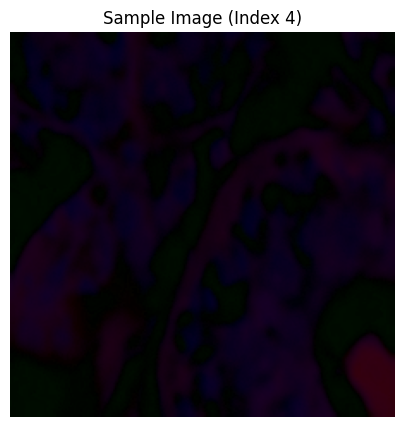


For Sample Image (Index 4):
Actual Label: benign
Predicted Label: benign


In [12]:
sample_index = 4
sample_image = X_test[sample_index]
sample_true_label_onehot = Y_test[sample_index]
sample_true_label = np.argmax(sample_true_label_onehot)  # Convert one-hot to 0 or 1
sample_true_label_name = 'benign' if sample_true_label == 0 else 'malignant'

# Extract features for the sample image
sample_hand_features = extract_handcrafted_features([sample_image])
sample_deep_features = extract_deep_features(np.expand_dims(sample_image, axis=0))
sample_fused_features = np.concatenate([sample_hand_features, sample_deep_features], axis=1)

# Predict the label for the sample image
sample_pred_label = svm_classifier.predict(sample_fused_features)[0]
sample_pred_label_name = 'benign' if sample_pred_label == 0 else 'malignant'

# Visualize the sample image
plt.figure(figsize=(5, 5))
plt.imshow(sample_image)
plt.title(f"Sample Image (Index {sample_index})")
plt.axis('off')
plt.show()

# Print predicted and actual labels
print(f"\nFor Sample Image (Index {sample_index}):")
print(f"Actual Label: {sample_true_label_name}")
print(f"Predicted Label: {sample_pred_label_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


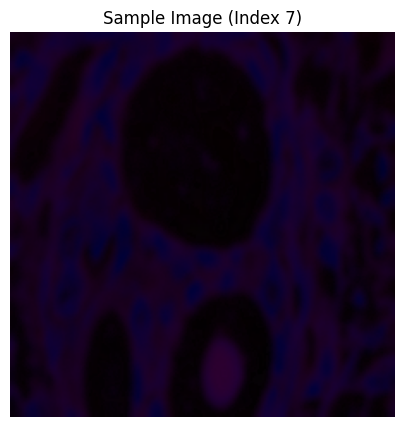


For Sample Image (Index 7):
Actual Label: malignant
Predicted Label: malignant


In [11]:
sample_index = 7
sample_image = X_test[sample_index]
sample_true_label_onehot = Y_test[sample_index]
sample_true_label = np.argmax(sample_true_label_onehot)  # Convert one-hot to 0 or 1
sample_true_label_name = 'benign' if sample_true_label == 0 else 'malignant'

# Extract features for the sample image
sample_hand_features = extract_handcrafted_features([sample_image])
sample_deep_features = extract_deep_features(np.expand_dims(sample_image, axis=0))
sample_fused_features = np.concatenate([sample_hand_features, sample_deep_features], axis=1)

# Predict the label for the sample image
sample_pred_label = svm_classifier.predict(sample_fused_features)[0]
sample_pred_label_name = 'benign' if sample_pred_label == 0 else 'malignant'

# Visualize the sample image
plt.figure(figsize=(5, 5))
plt.imshow(sample_image)
plt.title(f"Sample Image (Index {sample_index})")
plt.axis('off')
plt.show()

# Print predicted and actual labels
print(f"\nFor Sample Image (Index {sample_index}):")
print(f"Actual Label: {sample_true_label_name}")
print(f"Predicted Label: {sample_pred_label_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


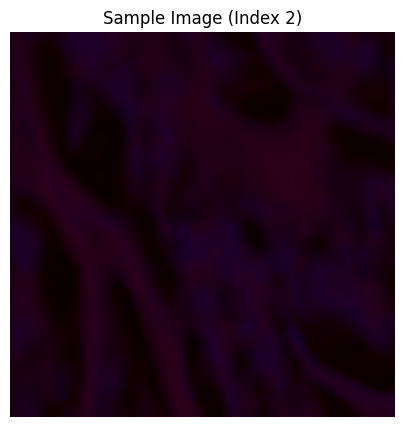


For Sample Image (Index 2):
Actual Label: malignant
Predicted Label: malignant


In [10]:
sample_index = 2
sample_image = X_test[sample_index]
sample_true_label_onehot = Y_test[sample_index]
sample_true_label = np.argmax(sample_true_label_onehot)  # Convert one-hot to 0 or 1
sample_true_label_name = 'benign' if sample_true_label == 0 else 'malignant'

# Extract features for the sample image
sample_hand_features = extract_handcrafted_features([sample_image])
sample_deep_features = extract_deep_features(np.expand_dims(sample_image, axis=0))
sample_fused_features = np.concatenate([sample_hand_features, sample_deep_features], axis=1)

# Predict the label for the sample image
sample_pred_label = svm_classifier.predict(sample_fused_features)[0]
sample_pred_label_name = 'benign' if sample_pred_label == 0 else 'malignant'

# Visualize the sample image
plt.figure(figsize=(5, 5))
plt.imshow(sample_image)
plt.title(f"Sample Image (Index {sample_index})")
plt.axis('off')
plt.show()

# Print predicted and actual labels
print(f"\nFor Sample Image (Index {sample_index}):")
print(f"Actual Label: {sample_true_label_name}")
print(f"Predicted Label: {sample_pred_label_name}")